# Example – Heat Transfer

## Introduction

Fire Dynamics Simulator (FDS) calculates the mechanisms of heat transfer taking into account the corresponding physical processes of convection and radiation. From the resulting heat flux onto a solid surface, the surface temperature as well as the temperature at a certain depth can be determined, depending on the material properties and the the respective boundary conditions. By default, FDS  only performs a transient, one-dimensional calculation of heat transfer. The objective of this exercise is to discuss the different influences of radiation and convection as well as the surface and material properties of a solid body on its heating in case of fire. The {download}`HeatTransfer.fds` input file should be used as a starting point.

## Setup
The extension of the computational domain is 

$$\small\sf [-0.8~m, 0.8~m] \times [0.0~m, 2.0~m] \times [0.0~m, 5.0~m]$$

:::{figure-md} fig-transfer-smv

<img src="figs/fds.png" width="100%">

SMV visualization of the geometry. The surface patch `HEATER`, which has a constant surface temperature of $1000^\circ C$ (`TMP_FRONT = 1000`) ,is colored reddish. The orange and yellow obstructions (`OBST`) depict different surfaces (`SURF`). The gray heat shield covers thermocouples and devices from a radiative impact.  
:::

## Heat Flux
FDS provides several output quantities related to the thermal exposure of solid surfaces (See section 21.10.7 [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf)).


The sum of radiative and convective energy absorbed at a solid surface is expressed by the `TOTAL HEAT FLUX` or `NET HEAT FLUX`:

$$\mf q_{\rm net}'' = \epsilon_{\rm s} \, \left(q_{\rm inc,rad}'' - \sigma \, T_{\rm s}^4 \right) + h \, (T_{\rm gas} - T_{\rm s}) \label{net_flux}$$

where $\mf \dot{q}_{\rm inc,rad}$ is the incident radiative heat flux (`INCIDENT HEAT FLUX`), $\mf \epsilon_{\rm s}$ is the surface emissivity, h is the convective heat transfer coefficient, $\mf T_{\rm s}$ is the surface temperature, and $\mf T_{\rm gas}$ is the gas temperature in the vicinity of the surface. The convective heat transfer coefficient, h, is calculated by FDS using the specified surface properties and the calculated near-boundary flow characteristics.

The radiative component can be evaluated separately by the `RADIATIVE HEAT FLUX` quantity:


$$\mf q_{\rm r}'' = \epsilon_{\rm s} \, \left( q_{\rm inc,rad}'' - \sigma \, T_{\rm s}^4 \right)$$

The convective component is given by `CONVECTIVE HEAT FLUX`:

$$\mf q_{\rm c}'' = h \, (T_{\rm gas} - T_{\rm s})$$

The heat flux on a component depends on its surface temperature, which is automatically calculated by FDS. The heat flux on a component with a predefined temperature, e.g. a water-cooled heat flux gauge can be evaluated by `GAUGE HEAT FLUX`. If not explicitly defined, $\mf T_{gauge}$ is assumed to be equal to the ambient temperature.

$$\mf q_{\rm gauge}'' = \epsilon_{\rm gauge} \, \left( q_{\rm inc,rad}'' - \sigma \, T_{\rm gauge}^4 \right) + h \, (T_{\rm gas} - T_{\rm gauge})$$

Quantities on a solid obstruction can be recorded using the `BNDF` namelist group. It can be defined similar to `SLCF` like:
```
&BNDF QUANTITY='NET HEAT FLUX', CELL_CENTERED=.TRUE. /
```
For more detailed information on how to set up `BNDF` in FDS please refer to section 21.5 [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf).

By default, the specified quantities are evaluated for the surfaces of all obstructions as well as the boundaries of the computational domain. You can prevent this with the parameter `BNDF_DEFAULT = .FALSE.` on the `MISC` line. Individual obstructions can then be turned back on with `BNDF_OBST=.TRUE.` on the appropriate `OBST` line.

In [1]:
import fdsreader
from fdsreader.bndf.utils import sort_patches_cartesian
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 1

root = '../../../../'

In [2]:
data_root = root + 'data/heat_transfer/HeatTransfer_0'
sim = fdsreader.Simulation(data_root)

def get_bndf_face(quantity, obstruction=0, orientation=-2):
    obst = sim.obstructions[0]
    patches = list()
    for sub_obst in obst.filter_by_orientation(orientation):
        # Get boundary data for a specific quantity
        sub_obst_data = sub_obst.get_data(quantity)
        patches.append(sub_obst_data.data[orientation])

        # Combine patches to a single face for plotting
        patches = sort_patches_cartesian(patches)

        shape_dim1 = sum([patch_row[0].shape[0] for patch_row in patches])
        shape_dim2 = sum([patch.shape[1] for patch in patches[0]])
        n_t = patches[0][0].n_t  # Number of timesteps

        face = np.empty(shape=(n_t, shape_dim1, shape_dim2))
        dim1_pos = 0
        dim2_pos = 0
        for patch_row in patches:
            d1 = patch_row[0].shape[0]
            for patch in patch_row:
                d2 = patch.shape[1]
                face[:, dim1_pos:dim1_pos + d1,
                dim2_pos:dim2_pos + d2] = patch.data
                dim2_pos += d2
            dim1_pos += d1
            dim2_pos = 0
    return face

total_hf = get_bndf_face('TOTAL HEAT FLUX')
convective_hf = get_bndf_face('CONVECTIVE HEAT FLUX')
radiative_hf = get_bndf_face('RADIATIVE HEAT FLUX')
gauge_hf = get_bndf_face('GAUGE HEAT FLUX')
incident_hf = get_bndf_face('INCIDENT HEAT FLUX')
vmin = 0
vmax = 80
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(15,30), sharey=True)
heatmap = ax1.imshow(total_hf[500].T, vmin=vmin, vmax=vmax, origin="lower", cmap="jet")
ax2.imshow(convective_hf[500].T, vmin=vmin, vmax=vmax, origin="lower", cmap="jet")
ax3.imshow(radiative_hf[500].T, vmin=vmin, vmax=vmax, origin="lower", cmap="jet")
ax4.imshow(incident_hf[500].T, vmin=vmin, vmax=vmax, origin="lower", cmap="jet")
ax5.imshow(gauge_hf[500].T, vmin=vmin, vmax=vmax, origin="lower", cmap="jet")
ax1.set_title("TOTAL HEAT FLUX")
ax2.set_title("CONVECTIVE HEAT FLUX")
ax3.set_title("RADIATIVE HEAT FLUX")
ax4.set_title("GAUGE HEAT FLUX")
ax5.set_title("INCIDENT HEAT FLUX")
ax1.set_xlabel("$n_{cells}~X$")
ax2.set_xlabel("$n_{cells}~X$")
ax3.set_xlabel("$n_{cells}~X$")
ax4.set_xlabel("$n_{cells}~X$")
ax5.set_xlabel("$n_{cells}~X$")
ax1.set_ylabel("$n_{cells}~Y$")

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.41, 0.02, 0.185])
cbar_ax.set_title('$kW / m^2$')
fig.colorbar(heatmap, cax=cbar_ax)
# ax5.colorbar(label="Temperature / $\sf ^\circ C$")
# plt.xlabel("$\sf N_{cells,x}$ / -")
# plt.ylabel("$\sf N_{cells,y}$ / -")
fig.savefig('figs/heatflux_bndf.svg', bbox_inches='tight')
plt.close()

:::{figure-md} heat-transfer-heatflux-bndf

<img src='figs/heatflux_bndf.svg' width="100%">

`TOTAL HEAT FLUX`, `CONVECTIVE HEAT FLUX`, `RADIATIVE HEAT FLUX`, `GAUGE HEAT FLUX` and `INCIDENT HEAT FLUX` on a solid obstruction opposite a flat radiator with a constant temperature of  $\mf T = 1000^\circ C$ 

:::

## Task 1
The local gas phase temperature at a certain cell can be evaluated via a simple `DEVC` with `QUANTITY = 'TEMPERATURE'`. The output of a thermocouple which lags the true gas temperature by an amount determined mainly by its size can be assessed by a `DEVC` with `QUANTITY = THERMOCOUPLE`. It takes into account the radiative and convective heat transfer to a small sphere. For this purpose, it must be assigned an emissivity and a diameter.  The properties can be assigned to a `DEVICE` via the `PROP_ID` attribute (see also section 20.1 of [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf). For detailed information on how to model thermocouples in FDS please refer to section 21.10.6.

**Tasks**
1. Place simple devices with `QUANTITY = 'TEMPERATURE'` and `THERMOCOUPLE` at X = 0, Y = 0.8 and heights z = 0.6 m (bottom), 2.6 m (behind heat shield), 4.4 m (top).  Run the simulation for at least 100 seconds and plot the temporal output of the devices. Discuss what effects lead to the differences between the two types of devices. For the thermocouples assume an `EMISSIVITY` of 0.9 and a diameter of d = 3 mm. 

:::{figure-md} heat-transfer-namelist-dependencies-prop

<img src="figs/flow_chart_prop.svg" width="70%">

Namelist dependencies `DEVC` (device) and `PROP` (property)
:::

In [9]:
data_root = root + 'data/heat_transfer/HeatTransfer_1'
sim = fdsreader.Simulation(data_root)
time = sim.devices['Time'].data
t_top = sim.devices['T_top'].data
tc_top = sim.devices['TC_top'].data
t_middle = sim.devices['T_middle'].data
tc_middle = sim.devices['TC_middle'].data
t_bottom = sim.devices['T_bottom'].data
tc_bottom = sim.devices['TC_bottom'].data
plt.plot(time, tc_top, label='Thermocouple top', color='red')
plt.plot(time, t_top, label='Temp Devc top', color='red', alpha=0.5 )
plt.plot(time, tc_middle, label='Thermocouple middle', color='green')
plt.plot(time, t_middle, label='Temp Devc middle', color='green', alpha=0.5)
plt.plot(time, tc_bottom, label='Thermocouple bottom',color='blue')
plt.plot(time, t_bottom, label='Temp Devc bottom', color='blue', alpha=0.5)
plt.xlabel("Time / s")
plt.ylabel("Temperature / $\circ C$")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0,100)
plt.savefig('figs/thermocouples.svg', bbox_inches='tight')
plt.close()

**1. Solution**

:::{figure-md} heat-transfer-thermocouples

<img src='figs/thermocouples.svg' width="80%">

Measured temperature of `THERMOCOUPLE` and simple `TEMPERATURE DEVC`
:::

## Task 2
In order to correctly compute the heat transfer within a solid obstruction, the thermal material properties `CONDUCTIVITY`, `SPECIF_HEAT` and `DENSITY` must be known. A new material can be defined via the `MATL` attribute. The available parameters for describing the material properties can be found at section 22.14 of [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf)). Another parameter influencing the heat conduction within a solid is its thermal effective `THICKNESS`. This is defined on the `SURF` line and is independent from the actual thickness of an obstruction.

The `EMISSIVITY` (default 0.9) can be set on the `SURF` or `MATL` line while the `MATL` parameter is given priority.

The back side boundary conditions of a solid obstruction can be defined on the `SURF` line as:
- `EXPOSED`: Calculates heat conduction through the wall into the space behind the wall (default)
- `INSULATED`: Prevents any heat loss from the back side of the material
- `VOID`: Always backs up to ambient temperature

::::{important}
The `THICKNESS` of a `SURF` ought to be the actual thickness of the “wall” through which FDS performs a 1-D heat conduction calculation. It is independent from the mesh cell width. If the obstruction is on the boundary of the domain or is more than one cell thick, then it is automatically assumed to back up to an air gap at ambient temperature.
::::

:::{figure-md} heat-transfer-namelist-dependencies-surf

<img src="figs/flow_chart_surf.svg" width="100%">

Namelist dependencies `OBST` (obstruction), `SURF` (surface), and `MATL` (material)
:::

**Tasks**
1. Define a new material "Steel" with the following material properties $\mf c_p = 0.5~kJ~/kg~K$, $\mf \lambda = 45.3~W~/m~K $ and $\mf \rho=7854~kg~m^{-3}$. Assign the material to the "SURF_1" (yellow) and "SURF_2" (orange). On the `SURF` line change the back side boundary condition of one of the surfaces to `INSULATED` and on the other to `EXPOSED` (See section 11.3.3 [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf)). Assume a `THICKNESS` of 10 mm (0.01 m). Analyse the `WALL TEMPERATURE` (on front surface) as well as the `INSIDE WALL TEMPERATURE` at depths 2.5 mm and 7.5 mm and the `BACK WALL TEMPERATURE` (on back surface) (see 21.2.1 and 21.2.3 [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf)). For this purpose a respective `DEVC` must be placed on the front surface of the solid `OBSTRUCTION`. The parameter `IOR` (Index of Orientation) is required for any device that is placed on the surface of a solid. It indicates the direction that the device points at. For example, `IOR = -1` means that the device is mounted on a wall that faces in the negative x direction. Run the simulation for 600 s and plot the indicated temperatures for both surfaces.

2. At which timestep does the difference between the `WALL TEMPERATURE` of both surfaces exceed a ratio of 5%?

3. Assign `VOID` and `EXPOSED` back wall boundary conditions to the respective surfaces and evaluate the `TEMPERATURE` at a gas phase cell directly behind the obstruction. Then extend the obstruction width to at least two cells and run the simulation again afterwards. Compare the measured temperatures. Make sure the devices are not within any obstruction as you change the width of the wall. 

**1. and 2. Solution**

In [8]:
data_root = root + 'data/heat_transfer/HeatTransfer_2_1'
sim = fdsreader.Simulation(data_root)
time = sim.devices['Time'].data

steel_exposed_front = sim.devices['Steel_exposed_front'].data
steel_exposed_025 = sim.devices['Steel_exposed_025'].data
steel_exposed_075 = sim.devices['Steel_exposed_075'].data
steel_exposed_back = sim.devices['Steel_exposed_back'].data

steel_insulated_front = sim.devices['Steel_insulated_front'].data
steel_insulated_025 = sim.devices['Steel_insulated_025'].data
steel_insulated_075 = sim.devices['Steel_insulated_075'].data
steel_insulated_back = sim.devices['Steel_insulated_back'].data

fig, ax1 = plt.subplots()

ax1.plot(time, steel_exposed_front, label="Front, back. exposed", color='blue')
ax1.plot(time, steel_exposed_025, label="d = 2.5 mm, back. exposed", color='red')
ax1.plot(time, steel_exposed_075, label="d = 7.5 mm, back. exposed", color='green')
ax1.plot(time, steel_exposed_back, label="Back, back. exposed", color='yellow')
ax1.plot(time, steel_insulated_front, label="Front, back. insulated", color='blue', linestyle='--')
ax1.plot(time, steel_insulated_025, label="2.5 mm, back. insulated", color='red', linestyle='--')
ax1.plot(time, steel_insulated_075, label="7.5 mm, back. insulated", color='green', linestyle='--')
ax1.plot(time, steel_insulated_back, label="Back, back. insulated", color='yellow', linestyle='--')

ax1.set_xlabel("Time / s")
ax1.set_ylabel("Temperature / $^\circ C$")
ax1.set_xlim(0,10)
ax1.set_ylim(20,35)
ax1.legend(ncol=1, bbox_to_anchor=(1.1, 1), loc='upper left')
ax1.grid(axis='x', linestyle='--', alpha=0.5)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('figs/backings_start.svg', bbox_inches='tight')

error = (steel_insulated_front-steel_exposed_front)/steel_insulated_front*100
ax2 = ax1.twinx()
ax2.plot(time, error, label = "rel. Error", color='purple')
handles_1, labels_1 = ax1.get_legend_handles_labels()
handles_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(handles_1+handles_2, labels_1+labels_2, ncol=1, bbox_to_anchor=(1.1, 1), loc='upper left')

ax2.set_ylabel("Rel. Error / %")
ax1.set_xlim(0,600)
ax2.set_ylim(0,20)

# ax1.set_ylim(20,600)
ax1.set_yticks(np.linspace(0,600,5))
ax2.set_yticks(np.linspace(0,20,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('figs/backings_end.svg', bbox_inches='tight')
plt.close()


:::{figure-md} heat-transfer-backings-start

<img src="figs/backings_start.svg" width="100%">

`WALL TEMPERATURE` and `INSIDE WALL TEMPERATURE` at several depths inside the solid steel obstruction within the first 10 seconds seconds of heating phase
:::

:::{figure-md} heat-transfer-backings-end

<img src="figs/backings_end.svg" width="100%">

`WALL TEMPERATURE` and `INSIDE WALL TEMPERATURE` at several depths inside the solid steel obstruction within the first 600 seconds seconds of heating phase. The purple line indicates the relative error between an insulated and exposed backing boundary condition. 
:::

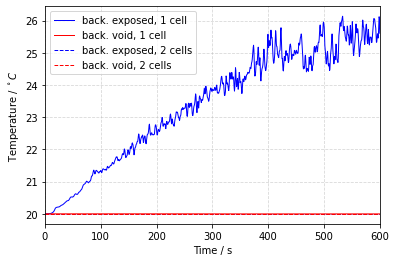

In [5]:
data_root = root + 'data/heat_transfer/HeatTransfer_2_2'
sim = fdsreader.Simulation(data_root)
time = sim.devices['Time'].data
exposed_temp_1cell = sim.devices['exposed_temp'].data
void_temp_1cell = sim.devices['void_temp'].data
data_root = root + 'data/heat_transfer/HeatTransfer_2_3'
sim = fdsreader.Simulation(data_root)
exposed_temp_2cell = sim.devices['exposed_temp'].data
void_temp_2cell = sim.devices['void_temp'].data

plt.plot(time, exposed_temp_1cell, label="back. exposed, 1 cell", color='blue')
plt.plot(time, void_temp_1cell, label="back. void, 1 cell", color='red')
plt.plot(time, exposed_temp_2cell, label="back. exposed, 2 cells", color='blue', linestyle='--')
plt.plot(time, void_temp_2cell, label="back. void, 2 cells", color='red', linestyle='--')

plt.xlabel("Time / s")
plt.ylabel("Temperature / $^\circ C$")
plt.xlim(0,600)
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.5)
plt.savefig('figs/two_cell_problem.svg', bbox_inches='tight')
plt.close()

**3. Solution**
:::{figure-md} heat-transfer-specific-heat-capacity

<img src="figs/two_cell_problem.svg" width="80%">

Comparison of heat conduction through a wall. The heat transfer into the space behind the wall is not computed if the obstruction is thicker than one cell.
:::

In [6]:
import numpy as np
import matplotlib.pyplot as plt
def density(p_20, t):
    if 20 <= t <= 115:
        p = p_20
    elif 115 < t <= 200:
        p = p_20 * (1-0.02*(t-115)/85)
    elif 200 < t <= 400:
        p = p_20 * (0.98 - 0.03*(t-200)/200)     
    elif 400 < t <= 1200:
        p = p_20 * (0.95 - 0.07*(t-400)/800)
    return p

def conductivity(t, how='upper'):
    if how == 'upper':
        k = 2-0.2451 * (t / 100) + 0.0107 * (t / 100)**2
    elif how == 'lower':
        k = 1.36 -0.136 * (t / 100) + 0.0057 *(t / 100)**2
    return k

def specific_heat(t, humidity=0):
    if 20 <= t <= 100:
        cp = 900
    elif 100 < t <= 200:
        if humidity == 0:
            cp = 900 + (t - 100)
        elif humidity == 1.5:
            if t <= 115:
                cp = 1470
            elif t > 115:
                cp = 1470 + (1000-1470)/(200-115)*(t-115)
        elif humidity == 3.0:
            if t <= 115:
                cp = 2020
            elif t > 115:
                cp = 2020 + (1000-2020)/(200-115)*(t-115)
    elif 200 < t <= 400:
        cp = 1000 + (t - 200) / 2
    elif 400 < t <= 1200:
        cp = 1100
    return cp/1000
 
temp_array = np.arange(20, 1200,1)
density_array = [density(2400, t) for t in temp_array]
conductivity_upper_array = [conductivity(t, how='upper') for t in temp_array]
conductivity_lower_array = [conductivity(t, how='lower') for t in temp_array]
specific_heat_array_0 = [specific_heat(t, humidity=0.0) for t in temp_array]
specific_heat_array_15 = [specific_heat(t, humidity=1.5) for t in temp_array]
specific_heat_array_30 = [specific_heat(t, humidity=3.0) for t in temp_array]

plt.plot(temp_array, specific_heat_array_0, color='black', label="humidity 0%")
plt.plot(temp_array, specific_heat_array_15, color='black', linestyle='--', label="humidity 1.5%")
plt.plot(temp_array, specific_heat_array_30, color='black', linestyle=':', label="humidity 3%")
plt.xlabel("Temperature / $^\circ C$")
plt.ylabel("Specific Heat / $kJ~/~kg~K$")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("figs/specific_heat_capacity.svg")
plt.close()

plt.plot(temp_array, conductivity_upper_array, color='black', label="upper limit")
plt.plot(temp_array, conductivity_lower_array, color='black', linestyle='--', label="lower limit")
plt.xlabel("Temperature / $^\circ C$")
plt.ylabel("Conductivity / $W~/~m~K$")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("figs/conductivity.svg")
plt.close()

plt.plot(temp_array, density_array, color='black')
plt.xlabel("Temperature / $^\circ C$")
plt.ylabel("Density / $kg~/~m^3$")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("figs/density.svg")
plt.close()

## Task 3

The assumption of constant thermal material properties is a simplification that often is sufficiently accurate. In some cases, however, it may be necessary to consider the actual temperature-dependent properties of a material or component. This can be done in FDS by defining a RAMP function, which describes a material parameter as a function of temperature (see section 11.3.2 [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf)).

Figure {numref}`heat-transfer-density` - {numref}`heat-transfer-conductivity` shows the temperature-dependent relationships for the specific heat capacity, thermal conductivity and density of concrete according to DIN EN 1992-1-2.

```{note}
In FDS only the `SPECIFIC_HEAT` and `CONDUCTIVITY` can be ramped while `DENSITY` and `EMISSIVITY` cannot. Unlike the fractional specification, such as in the definition of the HRR curve, the material properties are defined as absolute values in the `RAMP` function.
```

**Tasks**

1. At 20°C, read the values from {numref}`heat-transfer-density` - {numref}`heat-transfer-conductivity` and define a new material "concrete" with the corresponding material properties. Define another material taking into account the variable material properties. Therefore roughly map the corresponding progression curves using a RAMP function (max. 7 datapoints each). Assign the two materials to "SURF_1"  and "SURF_2" in the FDS file. 
2. Run the simulation for 600 s and compare the `WALL TEMPERATURE` for both surfaces as well as the `INSIDE WALL TEMPERATURE` at d = 10 mm. Assume the wall to have a thickness of 10 cm. Assume a humidity of 3 %. For the conductivity consider the upper limit.
:::{figure-md} heat-transfer-namelist-dependencies-ramp

<img src="figs/flow_chart_ramp.svg" width="70%">

Namelist dependencies `MATL` (material) and `RAMP` (ramp function)
:::

:::{figure-md} heat-transfer-density

<img src="figs/density.svg" width="80%">

Density of concrete as a function of temperature
:::


:::{figure-md} heat-transfer-specific-heat-capacity

<img src="figs/specific_heat_capacity.svg" width="80%">

Specific heat of concrete with quartz-containing additive as a function of temperature
:::

:::{figure-md} heat-transfer-conductivity

<img src="figs/conductivity.svg" width="80%">

Thermal conductivity of concrete
:::

**1. and 2. Solution**

In [7]:
data_root = root + 'data/heat_transfer/HeatTransfer_3'
sim = fdsreader.Simulation(data_root)
time = sim.devices['Time'].data

concrete_1_surf = sim.devices['Concrete_1_surf'].data
concrete_2_surf = sim.devices['Concrete_2_surf'].data
concrete_1_ins = sim.devices['Concrete_1_ins'].data
concrete_2_ins = sim.devices['Concrete_2_ins'].data
plt.plot(time, concrete_1_surf, color='blue', label="WALL Temp. RAMP MAT")
plt.plot(time, concrete_2_surf, color='red', label="WALL Temp. FIXED MAT")
plt.plot(time, concrete_1_ins, color='blue', linestyle='--', label="INSIDE WALL Temp. RAMP MAT")
plt.plot(time, concrete_2_ins, color='red', linestyle='--', label="INSIDE WALL Temp. FIXED MAT")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlabel("Time / s")
plt.ylabel("Temperature / $\circ^C$")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.savefig('figs/mat_prop.svg')
plt.close()

:::{figure-md} heat-transfer-ramp-mat-prop

<img src="figs/mat_prop.svg" width="80%">

`WALL TEMPERATURE` and `INSIDE WALL TEMPERATURE` of concrete `SURF` with fixed and temperature dependent material properties 